In [5]:
library(tidyverse)

In [6]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>%
    group_by(character, episode_number) %>%
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>%
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

# Question 1

The mean dialogue length and the dialogue count plot shows us whether a character may have had fewer seperate pieces of dialogue, while also maybe having one instance where they had to give a long speech per say. And vice versa, a character could have many distinct dialogue counts but could only be saying one word at a time. This plot displays the intersection between the two so we can see who the true main characters are compared to side characters, since the main characters would have many distinct dialogue counts while also having longer dialogue lengths.

# Question 2

a)

In [7]:
bev_per_ep <- dialogs_fixed |>
  filter(character == "BEVERLY",
         between(episode_number, 102, 126) | between(episode_number, 149, 174)) |>
  mutate(season = case_when(
    between(episode_number, 102, 126) ~ "Season 1",
    between(episode_number, 149, 174) ~ "Season 3")) |>
  group_by(season, episode_number) |>
  summarize(mean_dialog_length = mean(dialog_length),
    dialog_count = n(),
    .groups = "drop")


bev_table <- bev_per_ep |>
  group_by(season) |>
  summarize(avg_mean_dialog_length = mean(mean_dialog_length),
    avg_dialog_count = mean(dialog_count),
    .groups = "drop") |>
  arrange(season)
print(bev_table)

# A tibble: 2 × 3
  season   avg_mean_dialog_length avg_dialog_count
  <chr>                     <dbl>            <dbl>
1 Season 1                   56.5             25.4
2 Season 3                   67.0             19.6


b)

Based on these comments, we should see higher dialogue lengths and average dialogue counts in Season 3 compared to Season 1. The table shows us that she had higher average dialogue lengths but fewer distinct dialogue counts in Season 3 compared to 1. The fact that one of these categories was increased in Season 3 shows that there is some validity to her claims.

# Question 3

In [8]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)


# Tokenize, clean, and remove stop words
tokens <- dialogs_fixed %>%
  mutate(word_list = str_split(dialog, "\\s+")) %>%
  unnest(word_list) %>%
  mutate(word = str_remove_all(word_list, "[[:punct:]]"),
    word = str_to_lower(word),
    word = str_replace_all(word, "[0-9]+", "")) %>%
  filter(!is.na(word), word != "", !word %in% stop_words)

# Peek
tokens %>% head()

episode_number,character,dialog,dialog_length,word_list,word
<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,Captain's,captains
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,"log,",log
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,stardate,stardate
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,destination,destination
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,planet,planet
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,Cygnus,cygnus


b)

In [9]:
vocabbycharacter <- tokens |>
  group_by(character) |>
  summarize(total_words = n(),
    unique_words = n_distinct(word),
    vocab_richness = unique_words / total_words,
    .groups = "drop") |>
  arrange(desc(vocab_richness)) |>
  mutate(vocab_richness = round(vocab_richness, 3),
    total_words = as.integer(total_words),
    unique_words = as.integer(unique_words))
vocabbycharacter

character,total_words,unique_words,vocab_richness
<chr>,<int>,<int>,<dbl>
WESLEY,7597,2287,0.301
WORF,18805,4306,0.229
TROI,19440,4177,0.215
BEVERLY,22895,4868,0.213
DATA,45428,8556,0.188
GEORDI,31960,5444,0.170
RIKER,41794,6425,0.154
PICARD,79150,9212,0.116


c)

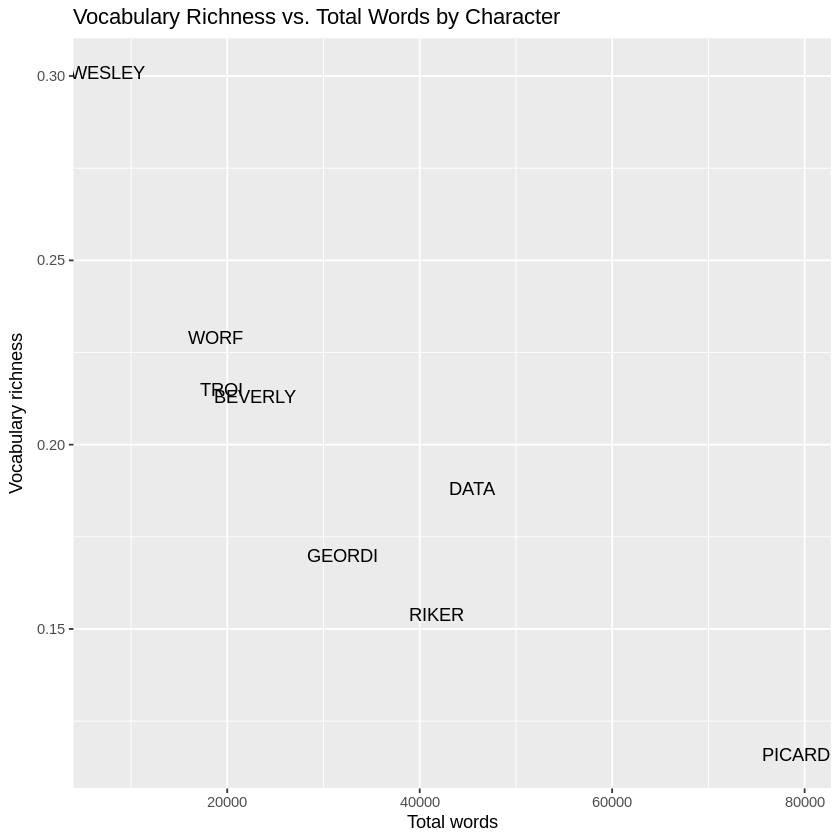

In [10]:

vocabbycharacter |>
  ggplot(aes(x = total_words, y = vocab_richness, label = character)) +
  geom_text(show.legend = FALSE) +
  labs(title = "Vocabulary Richness vs. Total Words by Character",
    x = "Total words",
    y = "Vocabulary richness") +
  theme()

d)

The chart shows a strong negative correlation between total words and vocabulary richness. Main characters such as Picard and Riker dominate the dialogue, but in turn they tend to repeat words. Supporting characters like Weskey have fewer lines of dialogue, but often have more variability.

# Question 4

a)

In [11]:
wesleylines <- dialogs_fixed |>
  filter(character == "WESLEY", episode_number > 174) |>
  group_by(episode_number) |>
  summarize(dialog_count = n(), .groups = "drop") |>
  arrange(episode_number)

wesleylines

episode_number,dialog_count
<dbl>,<int>
175,18
176,6
177,9
178,6
179,38
181,2
183,94
206,131
219,71


It looks like episode 183 is where he dropped out of the show. He doesn't make another appearance until episode 206.

b)

Episode 206

c)

In [12]:
wesley_last_main <- dialogs_fixed |>
  filter(character == "WESLEY", episode_number <= 182) |>
  arrange(episode_number) |>
  slice_tail(n = 1)

wesley_last_main

wesley_last_ever <- dialogs_fixed |>
  filter(character == "WESLEY") |>
  arrange(episode_number) |>
  slice_tail(n = 1)

wesley_last_ever

episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
181,WESLEY,Klingon vessels Vorn and Buruk holding stations at thirteen kilometers.,71


episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
272,WESLEY,"Good-bye, Mom.",14


# Question 5

a)

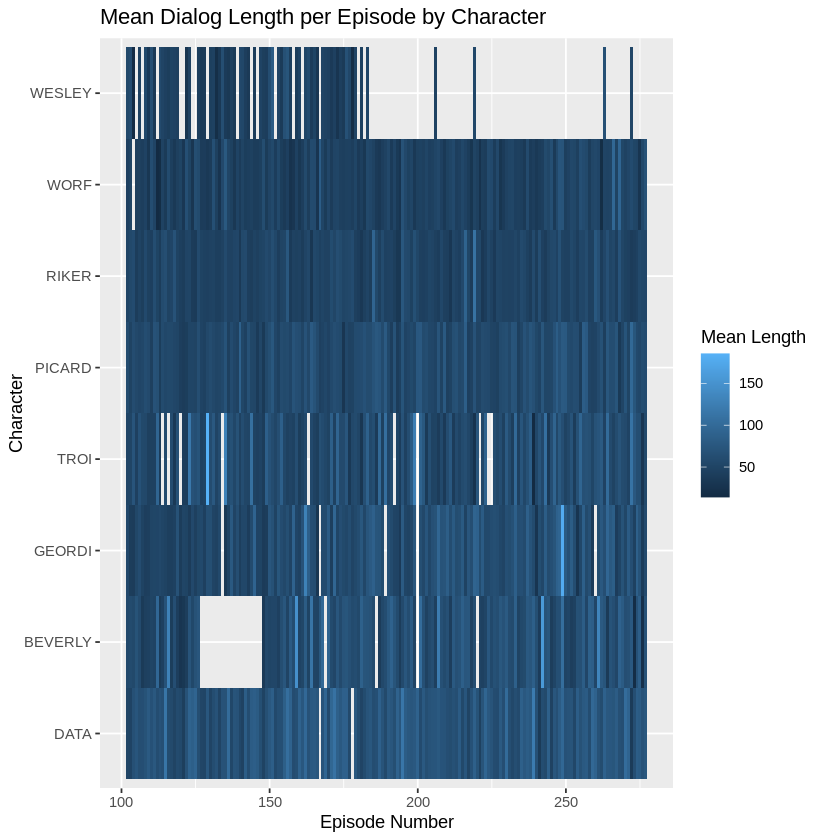

In [16]:
characterorder <- dialog_len_per_ep |>
  group_by(character) |>
  summarize(overall_mean = mean(mean_dialog_length), .groups = "drop") |>
  arrange(overall_mean)

character_order <- characterorder |> pull(character)

dialog_len_per_ep |>
  mutate(character = factor(character, levels = rev(char_order))) |>
  ggplot(aes(x = episode_number, y = character, fill = mean_dialog_length)) +
  geom_tile() +
  labs(title = "Mean Dialog Length per Episode by Character",
    x = "Episode Number",
    y = "Character",
    fill = "Mean Length")

b)

In [19]:
character_order <- dialog_len_per_ep |>
  group_by(character) |>
  summarize(overall_mean = mean(mean_dialog_length), .groups = "drop") |>
  arrange(overall_mean) |>
  pull(character)
dialog_len_per_ep |>
  mutate(character = factor(character, levels = char_order)) |>
  head()


character,episode_number,mean_dialog_length,dialog_count
<fct>,<dbl>,<dbl>,<int>
TROI,129,185.5000,2
GEORDI,249,179.0000,1
BEVERLY,242,158.0000,2
BEVERLY,159,146.5000,2
BEVERLY,261,133.5000,2
BEVERLY,116,129.7143,7


c)

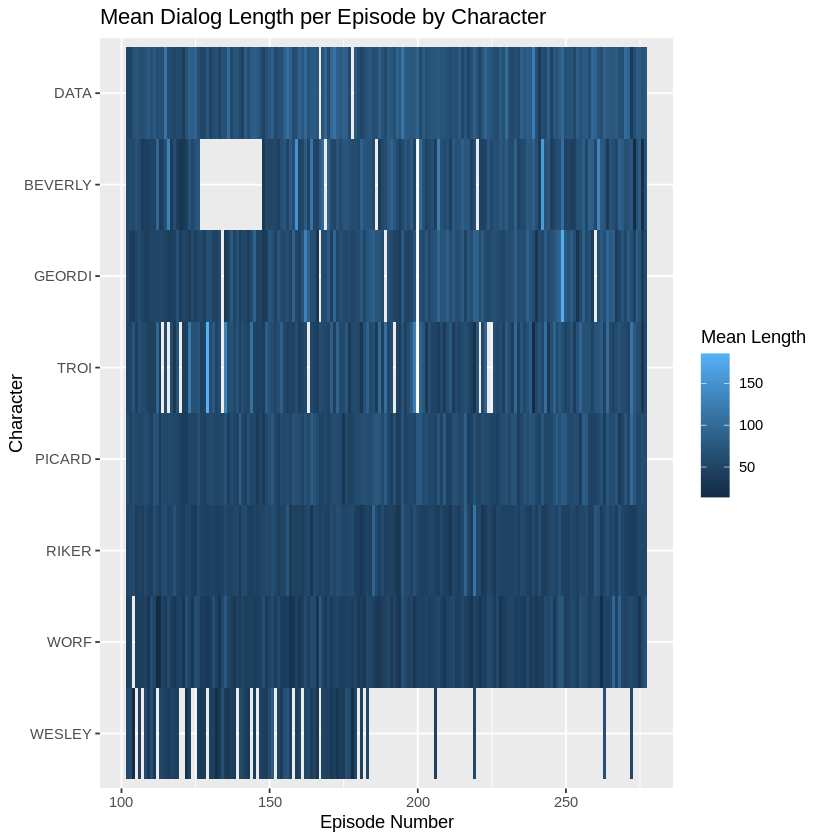

In [22]:
 dialog_len_per_ep |>
  mutate(character = factor(character, levels = char_order)) |>
  ggplot(aes(x = episode_number, y = character, fill = mean_dialog_length)) +
  geom_tile() +
  labs(title = "Mean Dialog Length per Episode by Character",
    x = "Episode Number",
    y = "Character",
    fill = "Mean Length")